In [1]:
from __future__ import print_function, division
import tensorflow as tf
import numpy as np

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# A bunch of utility functions

def show_images(images):
    images = np.reshape(images, [images.shape[0], -1])  # images reshape to (batch_size, D)
    sqrtn = int(np.ceil(np.sqrt(images.shape[0])))
    sqrtimg = int(np.ceil(np.sqrt(images.shape[1])))

    fig = plt.figure(figsize=(sqrtn, sqrtn))
    gs = gridspec.GridSpec(sqrtn, sqrtn)
    gs.update(wspace=0.05, hspace=0.05)

    for i, img in enumerate(images):
        ax = plt.subplot(gs[i])
        plt.axis('off')
        ax.set_xticklabels([])
        ax.set_yticklabels([])
        ax.set_aspect('equal')
        plt.imshow(img.reshape([sqrtimg,sqrtimg]))
    return

def preprocess_img(x):
    return 2 * x - 1.0

def deprocess_img(x):
    return (x + 1.0) / 2.0

def get_session():
    config = tf.ConfigProto()
    config.gpu_options.allow_growth = True
    session = tf.Session(config=config)
    return session


Extracting ./cs231n/datasets/MNIST_data/train-images-idx3-ubyte.gz
Extracting ./cs231n/datasets/MNIST_data/train-labels-idx1-ubyte.gz
Extracting ./cs231n/datasets/MNIST_data/t10k-images-idx3-ubyte.gz
Extracting ./cs231n/datasets/MNIST_data/t10k-labels-idx1-ubyte.gz


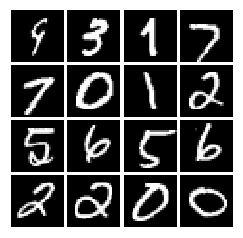

In [2]:
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets('./cs231n/datasets/MNIST_data', one_hot=False)

# show a batch
show_images(mnist.train.next_batch(16)[0])#picks exapmles and displays from mnist,if shuffle=True ,picks randomly


In [3]:
def leaky_relu(x, alpha=0.01):
    """Compute the leaky ReLU activation function.
    
    Inputs:
    - x: TensorFlow Tensor with arbitrary shape
    - alpha: leak parameter for leaky ReLU
    
    Returns:
    TensorFlow Tensor with the same shape as x
    """
    # TODO: implement leaky ReLU
    return tf.maximum(x,0.0)+alpha*tf.minimum(x,0.0)
       

In [4]:
def sample_noise(batch_size, dim):
    """Generate random uniform noise from -1 to 1.
    
    Inputs:
    - batch_size: integer giving the batch size of noise to generate
    - dim: integer giving the dimension of the the noise to generate
    
    Returns:
    TensorFlow Tensor containing uniform noise in [-1, 1] with shape [batch_size, dim]
    """
    # TODO: sample and return noise
    shape=np.array([batch_size,dim]) 
    return tf.random_uniform(shape,minval=-1,maxval=1)

In [5]:
def gan_loss(logits_real, logits_fake):
    """Compute the GAN loss.
    
    Inputs:
    - logits_real: Tensor, shape [batch_size, 1], output of discriminator
        Log probability that the image is real for each real image
    - logits_fake: Tensor, shape[batch_size, 1], output of discriminator
        Log probability that the image is real for each fake image
    
    Returns:
    - D_loss: discriminator loss scalar
    - G_loss: generator loss scalar
    """
    # TODO: compute D_loss and G_loss
    D_loss = None
    G_loss = None
    g=tf.nn.sigmoid_cross_entropy_with_logits(logits=logits_fake,labels=tf.ones_like(logits_fake))
    d1=tf.nn.sigmoid_cross_entropy_with_logits(logits=logits_real,labels=tf.ones_like(logits_real))
    d2=tf.nn.sigmoid_cross_entropy_with_logits(logits=logits_fake,labels=tf.zeros_like(logits_fake))
    d=d1+d2
    D_loss=tf.reduce_mean(d)
    G_loss=tf.reduce_mean(g)
    return D_loss, G_loss

In [6]:
def get_solvers(learning_rate=1e-3, beta1=0.5,beta2=0.999):
    """Create solvers for GAN training.
    
    Inputs:
    - learning_rate: learning rate to use for both solvers
    - beta1: beta1 parameter for both solvers (first moment decay)
    
    Returns:
    - D_solver: instance of tf.train.AdamOptimizer with correct learning_rate and beta1
    - G_solver: instance of tf.train.AdamOptimizer with correct learning_rate and beta1
    """
    D_solver = tf.train.AdamOptimizer(learning_rate=learning_rate,beta1=beta1,beta2=beta2)
    G_solver = tf.train.AdamOptimizer(learning_rate=learning_rate,beta1=beta1,beta2=beta2)
    
    return D_solver, G_solver

In [7]:
def run_a_gan(sess, G_train_step, G_loss, D_train_step, D_loss, G_extra_step, D_extra_step,\
              show_every=250, print_every=50, batch_size=128, num_epoch=10):
    """Train a GAN for a certain number of epochs.
    
    Inputs:
    - sess: A tf.Session that we want to use to run our data
    - G_train_step: A training step for the Generator
    - G_loss: Generator loss
    - D_train_step: A training step for the Generator
    - D_loss: Discriminator loss
    - G_extra_step: A collection of tf.GraphKeys.UPDATE_OPS for generator
    - D_extra_step: A collection of tf.GraphKeys.UPDATE_OPS for discriminator
    Returns:
        Nothing
    """
    # compute the number of iterations we need
    max_iter = int(mnist.train.num_examples*num_epoch/batch_size)
    for it in range(max_iter):
        # every show often, show a sample result
        if it % show_every == 0:
            samples = sess.run(G_sample)
            fig = show_images(samples[:16])
            plt.show()
            print()
        # run a batch of data through the network
        minibatch,minbatch_y = mnist.train.next_batch(batch_size)
        _, D_loss_curr = sess.run([D_train_step, D_loss], feed_dict={x: minibatch})
        _, G_loss_curr = sess.run([G_train_step, G_loss])

        # print loss every so often.
        # We want to make sure D_loss doesn't go to 0
        if it % print_every == 0:
            print('Iter: {}, D: {:.4}, G:{:.4}'.format(it,D_loss_curr,G_loss_curr))
    print('Final images')
    samples = sess.run(G_sample)

    fig = show_images(samples[:16])
    plt.show()

In [8]:
def discriminator(x):
    """Compute discriminator score for a batch of input images.
    
    Inputs:
    - x: TensorFlow Tensor of flattened input images, shape [batch_size, 784]
    
    Returns:
    TensorFlow Tensor with shape [batch_size, 1], containing the score 
    for an image being real for each input image.
    """
    with tf.variable_scope("discriminator"):
        # TODO: implement architecture
        input_layer = tf.reshape(x, [-1, 28, 28, 1])

        conv1 = tf.layers.conv2d(inputs=input_layer,filters=32,kernel_size=[5, 5],activation=leaky_relu)
        pool1 = tf.layers.max_pooling2d(inputs=conv1, pool_size=[2, 2], strides=2)

        conv2 = tf.layers.conv2d(inputs=pool1,filters=64,kernel_size=[5, 5],activation=leaky_relu)
        pool2 = tf.layers.max_pooling2d(inputs=conv2, pool_size=[2, 2], strides=2)
        
        [N, H, Wi, C] = pool2.get_shape().as_list()
        
        pool2_flat = tf.reshape(pool2, [-1, H*Wi*C])#pool2 is of shape(7,7,64)
        dense = tf.layers.dense(inputs=pool2_flat, units=1024, activation=leaky_relu)
        logits = tf.layers.dense(inputs=dense, units=1)
        #print(logits.get_shape())
        return logits

In [9]:
def generator(z):
    """Generate images from a random noise vector.
    
    Inputs:
    - z: TensorFlow Tensor of random noise with shape [batch_size, noise_dim]
    
    Returns:
    TensorFlow Tensor of generated images, with shape [batch_size, 784].
    """
    with tf.variable_scope("generator"):
        # TODO: implement architecture
        full_1=tf.layers.dense(inputs=z,units=1024,activation=tf.nn.relu)
        batch_norm_1=tf.layers.batch_normalization(full_1)
        #print(batch_norm_1.get_shape())
        full_2=tf.layers.dense(inputs=batch_norm_1,units=7*7*128,activation=tf.nn.relu)
        batch_norm_2=tf.layers.batch_normalization(full_2)
        
        #input_layer = tf.reshape(batch_norm_2, [-1, 28, 28, 8])
        input_layer = tf.reshape(batch_norm_2, [-1, 7, 7, 128])
        #print(input_layer.get_shape())
        #input_layer = tf.image.resize_images(batch_norm_2, [28, 28])
        
        [N, H, Wi, C] = input_layer.get_shape().as_list()
        #gen_W3 = tf.Variable(tf.random_normal([4,4,64,128], stddev=0.01), name='gen_W3')
        #output_shape=[N,14,14,64]
        #strides=[1,2,2,1]
        #bias = tf.Variable(tf.random_normal([64], stddev=0.0), dtype=tf.float32)
        #conv1 = tf.nn.conv2d_transpose(value=input_layer,filter=gen_W3,output_shape=output_shape,strides=strides,padding='SAME')
        #conv1_bias = tf.nn.bias_add(conv1, bias)
        #conv1=tf.nn.relu(conv1_bias)
        #batch_norm_3=tf.layers.batch_normalization(conv1,axis=3)
        #print(batch_norm_3.get_shape())
        
        #[N, H, Wi, C] = batch_norm_3.get_shape().as_list()
        #filter=tf.constant(0.1,shape=[4,4,1,64])
        #gen_W4 = tf.Variable(tf.random_normal([4,4,1,64], stddev=0.01), name='gen_W4')
        #output_shape=[N,28,28,1]
        #strides=[1,2,2,1]
        #img = tf.nn.conv2d_transpose(value=batch_norm_3,filter=gen_W4,output_shape=output_shape,strides=strides,padding='SAME')
        #bias = tf.Variable(tf.random_normal([1], stddev=0.0), dtype=tf.float32)
        #img_bias = tf.nn.bias_add(img, bias)
        #img= tf.nn.tanh(img_bias)
        
        deconv1 = tf.layers.conv2d_transpose(input_layer, filters=64, kernel_size=4, strides=2, padding="same", activation=tf.nn.relu)
        bnorm = tf.layers.batch_normalization(deconv1, axis=3)
        img = tf.layers.conv2d_transpose(bnorm, filters=1, kernel_size=4, strides=2, padding="same", activation=tf.nn.tanh)
        print(img.get_shape())
        img=tf.reshape(img,[-1,784])
        print(img.get_shape())
        
        return img

In [10]:
tf.reset_default_graph()

batch_size = 128
# our noise dimension
noise_dim = 96

# placeholders for images from the training dataset
x = tf.placeholder(tf.float32, [None, 784])
z = sample_noise(batch_size, noise_dim)
# generated images
G_sample = generator(z)

with tf.variable_scope("") as scope:
    #scale images to be -1 to 1
    logits_real = discriminator(preprocess_img(x))
    # Re-use discriminator weights on new inputs
    scope.reuse_variables()
    print(G_sample.get_shape())
    logits_fake = discriminator(G_sample)
    
# Get the list of variables for the discriminator and generator
D_vars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES,'discriminator')
G_vars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES,'generator') 

D_solver,G_solver = get_solvers()
D_loss, G_loss = gan_loss(logits_real, logits_fake)
D_train_step = D_solver.minimize(D_loss, var_list=D_vars)
G_train_step = G_solver.minimize(G_loss, var_list=G_vars)
D_extra_step = tf.get_collection(tf.GraphKeys.UPDATE_OPS,'discriminator')
G_extra_step = tf.get_collection(tf.GraphKeys.UPDATE_OPS,'generator')

(128, 28, 28, 1)
(128, 784)
(128, 784)


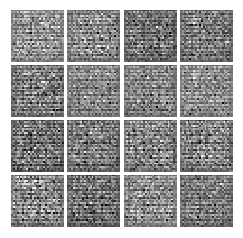


Iter: 0, D: 1.462, G:0.6558
Iter: 50, D: 0.0523, G:0.3918
Iter: 100, D: 1.563, G:2.67
Iter: 150, D: 1.291, G:1.803
Iter: 200, D: 0.8452, G:1.979


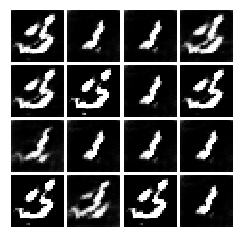


Iter: 250, D: 0.6447, G:0.9673
Iter: 300, D: 0.2683, G:3.657
Iter: 350, D: 1.336, G:3.193
Iter: 400, D: 0.4101, G:3.515
Iter: 450, D: 0.2767, G:2.333


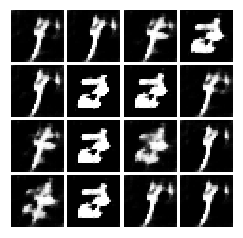


Iter: 500, D: 0.3957, G:2.784
Iter: 550, D: 0.5501, G:3.525
Iter: 600, D: 0.2913, G:3.001
Iter: 650, D: 0.437, G:3.725
Iter: 700, D: 1.378, G:7.38


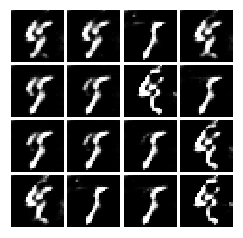


Iter: 750, D: 0.4632, G:2.966
Iter: 800, D: 0.6238, G:4.027
Iter: 850, D: 0.3539, G:2.752
Iter: 900, D: 0.3772, G:2.365
Iter: 950, D: 0.2991, G:3.349


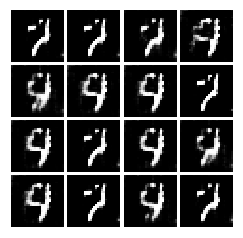


Iter: 1000, D: 0.3347, G:3.137
Iter: 1050, D: 0.3259, G:2.951
Iter: 1100, D: 0.1907, G:4.26
Iter: 1150, D: 0.7574, G:5.163
Iter: 1200, D: 0.2332, G:4.012


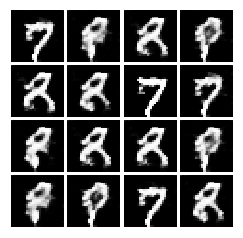


Iter: 1250, D: 0.9687, G:1.909
Iter: 1300, D: 0.04498, G:4.952
Iter: 1350, D: 0.9895, G:2.597
Iter: 1400, D: 0.3578, G:9.22
Iter: 1450, D: 0.2468, G:4.45


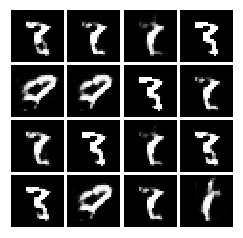


Iter: 1500, D: 0.4438, G:3.772
Iter: 1550, D: 0.1452, G:4.539
Iter: 1600, D: 0.7264, G:11.17
Iter: 1650, D: 0.114, G:4.421
Iter: 1700, D: 0.1662, G:5.367


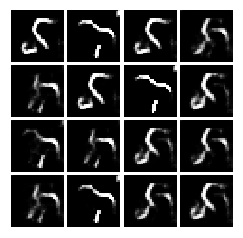


Iter: 1750, D: 0.1512, G:4.754


In [ ]:
with get_session() as sess:
    sess.run(tf.global_variables_initializer())
    run_a_gan(sess,G_train_step,G_loss,D_train_step,D_loss,G_extra_step,D_extra_step,num_epoch=40)